

The project has the following requirement:

- [X] The train, validation and test datasets should be composed of at least 2000, 1000 and 1000 images, respectively
- [X] RGB images should be used (three channels);
- [X] At least one model architecture (let’s call it Model S) should be designed from scratch;
- [X] At least two distinct loss functions should be tried;
- [X] At least two distinct optimizers should be tried;
- [X] At least two distinct regularization techniques should be tried;
- [X] Model S should be trained both with and without data augmentation;
- [X] Transfer learning (let’s call it Model T) should be tried with both feature extraction and fine tuning;
- [X] Model T should also be trained both with and without data augmentation.

In [117]:
from google.colab import drive
drive.mount('/content/drive')
from keras import layers, models
import pandas as pd
import numpy as np
import os, shutil
from keras.utils import image_dataset_from_directory
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.regularizers import l2, l1, L1L2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




**Como temos várias variáveis no nosso dataset vamos criar um loop para criar o caminho para o teste, treino e validação das varias variáveis, vou deixar em comentário a parte do codigo que imprime os caminhos pois apenas serve para confirmar**


Our dataset consists of a bundle of different vehicle images that we used to create our CNN classification.

The dataset its available on [kaggle](www.kaggle.com/datasets/iamsandeepprasad/vehicle-data-set) and is divided into 17 categories:

*   [*Ambulance*](https://en.wikipedia.org/wiki/Ambulance)
*   [*Barge*](https://en.wikipedia.org/wiki/Barge)
*   [*Bicycle*](https://en.wikipedia.org/wiki/Bicycle)
*   [*Boat*](https://en.wikipedia.org/wiki/Boat)
*   [*Bus*](https://en.wikipedia.org/wiki/Bus)
*   [*Car*](https://en.wikipedia.org/wiki/Car)
*   [*Cart*](https://en.wikipedia.org/wiki/Cart)
*   [*Carterpilar*](https://pt.wikipedia.org/wiki/Caterpillar_Inc.)
*   [*Helicopter*](https://pt.wikipedia.org/wiki/Helic%C3%B3ptero)
*   [*Limosine*](https://pt.wikipedia.org/wiki/Limusina)
*   [*Motorcycle*](https://en.wikipedia.org/wiki/Motorcycle)
*   [*Segway*](https://en.wikipedia.org/wiki/Segway)
*   [*Snowmobile*](https://en.wikipedia.org/wiki/Snowmobile)
*   [*Tank*](https://pt.wikipedia.org/wiki/Carro_de_combate)
*   [*Taxi*](https://pt.wikipedia.org/wiki/T%C3%A1xi)
*   [*TrucK*](https://en.wikipedia.org/wiki/Truck)
*   [*Van*](https://en.wikipedia.org/wiki/Van)

To divide the dataset into three parts—train, test, and validation—we needed to reorganize the dataset, which was originally divided into two main folders: one for training and another for testing, with XX images for training and XX for testing divided into 17 classes.

For this purpose, we used the following Node.js code to organize and label images from our dataset. The process was straightforward and involved moving and renaming the images, and then splitting them into training, test, and validation folders according to their labels. Let's explain each part of the code:

We defined the path and the variables to be used:
```
// Dataset URL: https://www.kaggle.com/datasets/iamsandeepprasad/vehicle-data-set
// Extract to folder 'cardataset/'
// O que devemos ter: 'cardataset/test' e 'cardataset/train'
// Instalar nodeJS
// Abrir a linha de comandos na pasta dos ficheiro server.js e pasta 'cardataset/'
// Correr o comando 'node server.js'
// Demora cerca de 5 a 10 min a executar

const fs = require('node:fs');
const folderPath = 'cardataset';
const letters = ['a', 'b', 'c', 'd', 'e'];
const labels = [
    'Ambulance',
    'Barge',
    'Bicycle',
    'Boat',
    'Bus',
    'Car',
    'Cart',
    'Caterpillar',
    'Helicopter',
    'Limousine',
    'Motorcycle',
    'Segway',
    'Snowmobile',
    'Tank',
    'Taxi',
    'Truck',
    'Van'
];
```
We read the main and secondary folders, and called the renameAndMoveFiles function to rename and move the files from the original structure to the root directory with a new name
```
moveAndLabelToRoot();
//splitImagesToTheCorrectFolders();
function moveAndLabelToRoot(){
    const auxFolders1 = readMainDir();
    let increment = 0;
    auxFolders1.forEach(i => {
        const auxFolders2 = readSecondaryDir(i);
        auxFolders2.forEach(x => {
            renameAndMoveFiles(folderPath + '/' + i + '/' + x, x, increment);
        });
        increment++;
    });
    splitImagesToTheCorrectFolders();
}

function renameAndMoveFiles(path, name, index){
    try {
        const files = fs.readdirSync(path);
        let increment = 0;
        files.forEach(i => {
            increment++;
            fs.renameSync(path + '/' + i, folderPath + '/' + name + '-' + letters[index] + increment + '.jpg');
            console.log("File " + i + ' renamed and moved with success!');
        })
    } catch (error) {
        console.log("error renameAndMoveFiles: " + error);
    }
}
```
We Split the renamed images into the train, test, and validation folders:

```
function splitImagesToTheCorrectFolders(){
    if(!fs.existsSync(folderPath + '/test')){
        fs.mkdirSync(folderPath + '/test');    
    }
    if(!fs.existsSync(folderPath + '/train')){
        fs.mkdirSync(folderPath + '/train');    
    }
    if(!fs.existsSync(folderPath + '/validation')){
        fs.mkdirSync(folderPath + '/validation');    
    }

    try {
        labels.forEach(i => {
            if(!fs.existsSync(folderPath + '/test/' + i)){
                fs.mkdirSync(folderPath + '/test/' + i);    
            }
            if(!fs.existsSync(folderPath + '/train/' + i)){
                fs.mkdirSync(folderPath + '/train/' + i);    
            }
            if(!fs.existsSync(folderPath + '/validation/' + i)){
                fs.mkdirSync(folderPath + '/validation/' + i);    
            }
            let files = fs.readdirSync(folderPath).filter(fn => fn.startsWith(i));
            //train
            let numElements = Math.floor(files.length * 0.5);
            const filesToMoveTrain = files.splice(0, numElements);
            filesToMoveTrain.forEach(x => {
                fs.renameSync(folderPath + '/' + x, folderPath + '/train/' + i + '/' + x);
                console.log('File ' + x + ' moved to train folder with success!');
            });

            //test
            numElements = Math.floor(files.length * 0.5);
            const filesToMoveTest = files.splice(0, numElements);
            filesToMoveTest.forEach(x => {
                fs.renameSync(folderPath + '/' + x, folderPath + '/test/' + i + '/' + x);
                console.log('File ' + x + ' moved to test folder with success!');
            });

            //validation
            files.forEach(x => {
                fs.renameSync(folderPath + '/' + x, folderPath + '/validation/' + i + '/' + x);
                console.log('File ' + x + ' moved to validation folder with success!');
            });
        });
    } catch (error) {
        console.log("error splitImagesToTheCorrectFolders: " + error);
    }
}
```
The helper functions read the main and secondary directories:

```
function readMainDir(){
    try {
        const folders = fs.readdirSync(folderPath);
        return folders;
    } catch (error) {
        console.log("error readMainDir: " + error);
        return [];
    }
}

function readSecondaryDir(path){
    try {
        const folders = fs.readdirSync(folderPath + '/' + path);
        return folders;
    } catch (error) {
        console.log("error readSecondaryDir: " + error);
        return [];
    }
}
```
After this process, we have a dataset divided into training, test, and validation sets with 13947, 7009, and 7017 images, respectively.

In [ ]:
dir_base = '/content/drive/MyDrive/cardataset'
treino = '/train'
teste = '/test'
validacao = '/validation'
veiculos = ['Ambulance', 'Barge', 'Bicycle', 'Boat', 'Bus', 'Car','Cart', 'Caterpillar', 'Helicopter', 'Limousine', 'Motorcycle', 'Segway', 'Snowmobile', 'Tank', 'Taxi', 'Truck', 'Van']
for veiculo in veiculos:
    globals()[f'{veiculo}_treino_dir'] = dir_base + treino +"/"+ veiculo
    globals()[f'{veiculo}_teste_dir'] = dir_base + teste +"/"+  veiculo
    globals()[f'{veiculo}_val_dir'] = dir_base + validacao +"/"+ veiculo
for veiculo in veiculos:
    print(f'{veiculo}_treino_dir = {globals()[f"{veiculo}_treino_dir"]}')
    print(f'{veiculo}_teste_dir = {globals()[f"{veiculo}_teste_dir"]}')
    print(f'{veiculo}_val_dir = {globals()[f"{veiculo}_val_dir"]}')

Ambulance_treino_dir = /content/drive/MyDrive/cardataset/train/Ambulance
Ambulance_teste_dir = /content/drive/MyDrive/cardataset/test/Ambulance
Ambulance_val_dir = /content/drive/MyDrive/cardataset/validation/Ambulance
Barge_treino_dir = /content/drive/MyDrive/cardataset/train/Barge
Barge_teste_dir = /content/drive/MyDrive/cardataset/test/Barge
Barge_val_dir = /content/drive/MyDrive/cardataset/validation/Barge
Bicycle_treino_dir = /content/drive/MyDrive/cardataset/train/Bicycle
Bicycle_teste_dir = /content/drive/MyDrive/cardataset/test/Bicycle
Bicycle_val_dir = /content/drive/MyDrive/cardataset/validation/Bicycle
Boat_treino_dir = /content/drive/MyDrive/cardataset/train/Boat
Boat_teste_dir = /content/drive/MyDrive/cardataset/test/Boat
Boat_val_dir = /content/drive/MyDrive/cardataset/validation/Boat
Bus_treino_dir = /content/drive/MyDrive/cardataset/train/Bus
Bus_teste_dir = /content/drive/MyDrive/cardataset/test/Bus
Bus_val_dir = /content/drive/MyDrive/cardataset/validation/Bus
Car_tre

However, during dataset processing, we discovered that the folder labeled "Carterpiller" was incorrectly classified because the images inside primarily depicted [carterpiller](https://en.wikipedia.org/wiki/Caterpillar) as insects, rather than  [carterpiller](https://en.wikipedia.org/wiki/Caterpillar_Inc.) as a construction equipment/veichle.
For clarity in the project, we decided to remove that folder from our dataset. Therefore, after this process, our dataset was divided into 14019, 6926, and 6934 images for training, test, and validation, respectively.
So we gona creat our path for the train, test and validation set:

In [ ]:
dados_iniciais=[]
for veiculo in veiculos:
    treino_dir = dir_base + treino + "/" + veiculo
    teste_dir = dir_base + teste + "/" + veiculo
    val_dir = dir_base + validacao + "/" + veiculo
    num_treino = len([file for file in os.listdir(treino_dir) if file.endswith('.jpg') or file.endswith('.png')])
    num_teste = len([file for file in os.listdir(teste_dir) if file.endswith('.jpg') or file.endswith('.png')])
    num_val = len([file for file in os.listdir(val_dir) if file.endswith('.jpg') or file.endswith('.png')])
    dados_iniciais.append({
        'Veículo': veiculo,
        'Treino Dir': treino_dir,
        'Quantidade Treino': num_treino,
        'Teste Dir': teste_dir,
        'Quantidade Teste': num_teste,
        'Validação Dir': val_dir,
        'Quantidade Validação': num_val
    })

pd.DataFrame(dados_iniciais)

,Veículo,Treino Dir,Quantidade Treino,Teste Dir,Quantidade Teste,Validação Dir,Quantidade Validação
0,Ambulance,/content/drive/MyDrive/cardataset/train/Ambulance,66,/content/drive/MyDrive/cardataset/test/Ambulance,33,/content/drive/MyDrive/cardataset/validation/A...,33
1,Barge,/content/drive/MyDrive/cardataset/train/Barge,101,/content/drive/MyDrive/cardataset/test/Barge,50,/content/drive/MyDrive/cardataset/validation/B...,51
2,Bicycle,/content/drive/MyDrive/cardataset/train/Bicycle,809,/content/drive/MyDrive/cardataset/test/Bicycle,404,/content/drive/MyDrive/cardataset/validation/B...,405
3,Boat,/content/drive/MyDrive/cardataset/train/Boat,4347,/content/drive/MyDrive/cardataset/test/Boat,2174,/content/drive/MyDrive/cardataset/validation/Boat,2174
4,Bus,/content/drive/MyDrive/cardataset/train/Bus,1066,/content/drive/MyDrive/cardataset/test/Bus,533,/content/drive/MyDrive/cardataset/validation/Bus,534
5,Car,/content/drive/MyDrive/cardataset/train/Car,3416,/content/drive/MyDrive/cardataset/test/Car,1708,/content/drive/MyDrive/cardataset/validation/Car,1707
6,Cart,/content/drive/MyDrive/cardataset/train/Cart,0,/content/drive/MyDrive/cardataset/test/Cart,0,/content/drive/MyDrive/cardataset/validation/Cart,1
7,Caterpillar,/content/drive/MyDrive/cardataset/train/Caterp...,165,/content/drive/MyDrive/cardataset/test/Caterpi...,83,/content/drive/MyDrive/cardataset/validation/C...,83
8,Helicopter,/content/drive/MyDrive/cardataset/train/Helico...,334,/content/drive/MyDrive/cardataset/test/Helicopter,167,/content/drive/MyDrive/cardataset/validation/H...,167
9,Limousine,/content/drive/MyDrive/cardataset/train/Limousine,37,/content/drive/MyDrive/cardataset/test/Limousine,18,/content/drive/MyDrive/cardataset/validation/L...,19


According to our latest assessment, we found some classes lacking the necessary number of images to correctly identify certain types of vehicles, such as carts. Therefore, we need to reorganize our dataset based on this new information.

Step 1 - We need to visually inspect our dataset to identify the types of

*   **Step 1** - We need to visually inspect our dataset to identify the types of vehicles included.
*   **Step 2** - Establish the minimum number of images required for each vehicle to be considered acceptable for our classification task (we have decided on 100 images).
*   **Step 3** - Vehicles with fewer than **500 images** we will use data augmentation process in order to increase.






In [ ]:
quantidades = []
for veiculo in veiculos:
    treino_dir = dir_base + treino + "/" + veiculo
    teste_dir = dir_base + teste + "/" + veiculo
    val_dir = dir_base + validacao + "/" + veiculo

    num_treino = len([file for file in os.listdir(treino_dir) if file.endswith('.jpg') or file.endswith('.png')])
    num_teste = len([file for file in os.listdir(teste_dir) if file.endswith('.jpg') or file.endswith('.png')])
    num_val = len([file for file in os.listdir(val_dir) if file.endswith('.jpg') or file.endswith('.png')])

    Totalimagens=num_treino + num_teste + num_val
    quantidades.append({'Veículo': veiculo, 'Total de Imagens': Totalimagens})

pd.DataFrame(quantidades)

,Veículo,Total de Imagens
0,Ambulance,132
1,Barge,202
2,Bicycle,1618
3,Boat,8695
4,Bus,2133
5,Car,6831
6,Cart,1
7,Caterpillar,331
8,Helicopter,668
9,Limousine,74


So according to the the step 2 we exclude the Cart and the Limousine set and with that we close the dataset to apply our model.


In [ ]:
dir_base = '/content/drive/MyDrive/cardataset'
treino = '/train'
teste = '/test'
validacao = '/validation'

quantidades = []
veiculos = ['Ambulance', 'Barge', 'Bicycle', 'Boat', 'Bus', 'Car', 'Helicopter','Motorcycle', 'Segway', 'Snowmobile', 'Tank', 'Taxi', 'Truck', 'Van']
for veiculo in veiculos:
    treino_dir = dir_base + treino + "/" + veiculo
    teste_dir = dir_base + teste + "/" + veiculo
    val_dir = dir_base + validacao + "/" + veiculo

    num_treino = len([file for file in os.listdir(treino_dir) if file.endswith('.jpg') or file.endswith('.png')])
    num_teste = len([file for file in os.listdir(teste_dir) if file.endswith('.jpg') or file.endswith('.png')])
    num_val = len([file for file in os.listdir(val_dir) if file.endswith('.jpg') or file.endswith('.png')])

    Totalimagens=num_treino + num_teste + num_val
    quantidades.append({'Veículo': veiculo, 'Total de Imagens': Totalimagens})

pd.DataFrame(quantidades)

,Veículo,Total de Imagens
0,Ambulance,132
1,Barge,202
2,Bicycle,1618
3,Boat,8695
4,Bus,2133
5,Car,6831
6,Helicopter,668
7,Motorcycle,2986
8,Segway,153
9,Snowmobile,123


So up we can see the dataset that we wanna work it, but that dataset its in one directory at my drive that contains the carterpiller, cart and limouseine, imagens that we decided not contemple.

So we gona creat a new folder to work only with the subtset decided.

novo_dir_base = '/content/drive/MyDrive/cardataset_limpo'

In [ ]:
#novo_dir_base = '/content/drive/MyDrive/cardataset_limpo'
#def copiar_imagens(origem, destino):
    #if not os.path.exists(destino):
        #os.makedirs(destino)
    #for file in os.listdir(origem):
        #if file.endswith('.jpg') or file.endswith('.png'):
            #shutil.copy(os.path.join(origem, file), os.path.join(destino, file))
#for veiculo in veiculos:
    #treino_dir = os.path.join(dir_base, treino[1:], veiculo)
    #teste_dir = os.path.join(dir_base, teste[1:], veiculo)
    #val_dir = os.path.join(dir_base, validacao[1:], veiculo)
    #novo_treino_dir = os.path.join(novo_dir_base, treino[1:], veiculo)
    #novo_teste_dir = os.path.join(novo_dir_base, teste[1:], veiculo)
    #novo_val_dir = os.path.join(novo_dir_base, validacao[1:], veiculo)
    #copiar_imagens(treino_dir, novo_treino_dir)
    #copiar_imagens(teste_dir, novo_teste_dir)
    #copiar_imagens(val_dir, novo_val_dir)

Imagens copiadas com sucesso.



So the final dataset has 13817 images to train, 6908 to test and 6914 to validation belonging to 14 classes.


*   [*Ambulance*](https://en.wikipedia.org/wiki/Ambulance)
*   [*Barge*](https://en.wikipedia.org/wiki/Barge)
*   [*Bicycle*](https://en.wikipedia.org/wiki/Bicycle)
*   [*Boat*](https://en.wikipedia.org/wiki/Boat)
*   [*Bus*](https://en.wikipedia.org/wiki/Bus)
*   [*Car*](https://en.wikipedia.org/wiki/Car)
*   [*Helicopter*](https://pt.wikipedia.org/wiki/Helic%C3%B3ptero)
*   [*Motorcycle*](https://en.wikipedia.org/wiki/Motorcycle)
*   [*Segway*](https://en.wikipedia.org/wiki/Segway)
*   [*Snowmobile*](https://en.wikipedia.org/wiki/Snowmobile)
*   [*Tank*](https://pt.wikipedia.org/wiki/Carro_de_combate)
*   [*Taxi*](https://pt.wikipedia.org/wiki/T%C3%A1xi)
*   [*TrucK*](https://en.wikipedia.org/wiki/Truck)
*   [*Van*](https://en.wikipedia.org/wiki/Van)


- [X] ~~The train, validation and test datasets should be composed of at least 2000, 1000 and 1000 images, respectively~~
- [X] ~~RGB images should be used (three channels);~~

So we gonna define our set of train, test and validation:

In [2]:
novo_dir_base = '/content/drive/MyDrive/cardataset_limpo'
treino = '/train'
teste = '/test'
validacao = '/validation'
dir_base=novo_dir_base
amostra_treino=image_dataset_from_directory((dir_base + treino),image_size=(150,150), batch_size=32, label_mode='categorical')
amostra_teste=image_dataset_from_directory((dir_base + teste),image_size=(150,150), batch_size=32, label_mode='categorical')
amostra_validacao=image_dataset_from_directory((dir_base + validacao),image_size=(150,150), batch_size=32, label_mode='categorical')
amostra_treino_labels = amostra_treino.class_names
amostra_treste_labels = amostra_teste.class_names
amostra_validacao_labels = amostra_validacao.class_names

Found 13817 files belonging to 14 classes.
Found 6908 files belonging to 14 classes.
Found 6914 files belonging to 14 classes.


The next two blocks of code are commented out because they were part of the process just to test some information.




In [ ]:
#for data_batch, labels_batch in amostra_treino:
  #print('Amostra de treino')
  #print('data batch shape:',data_batch.shape)
  #print('labels batch shape:', labels_batch.shape)
  #break

Amostra de treino
data batch shape: (32, 150, 150, 3)
labels batch shape: (32, 17)


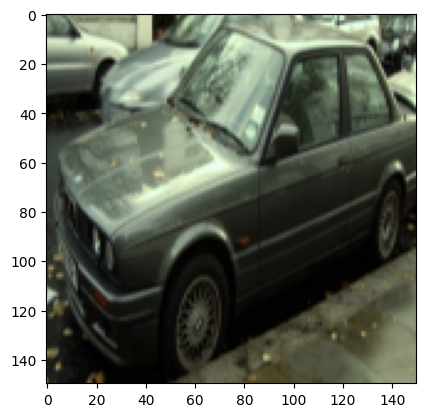

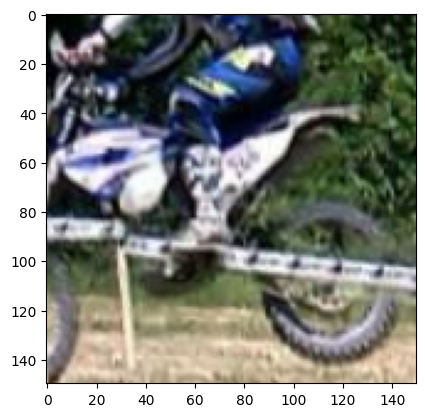

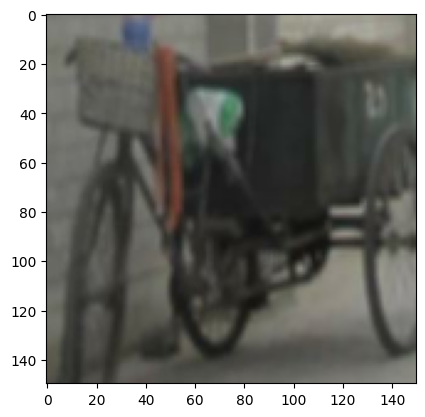

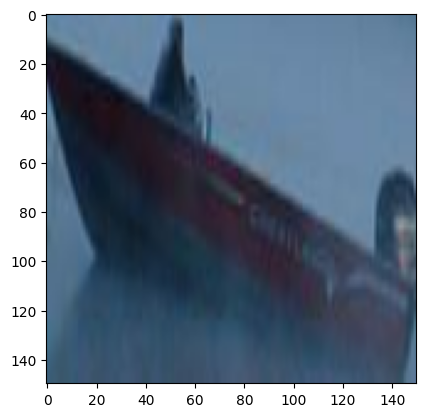

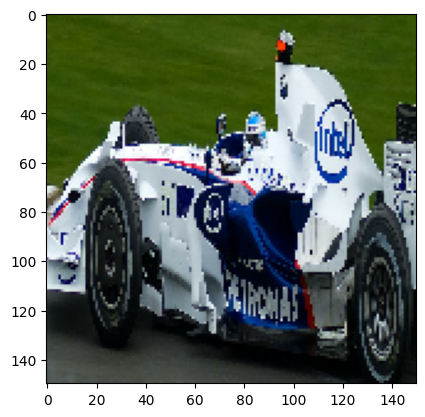

In [ ]:
#for data_batch, _ in amostra_treino.take(1):
  #for i in range(5):
    #plt.imshow(data_batch[i].numpy().astype('uint8'))
    #plt.show()

Now we we gonna creat our model

 - [X] ~~At least one model architecture (let’s call it Model S) should be designed from scratch;~~

 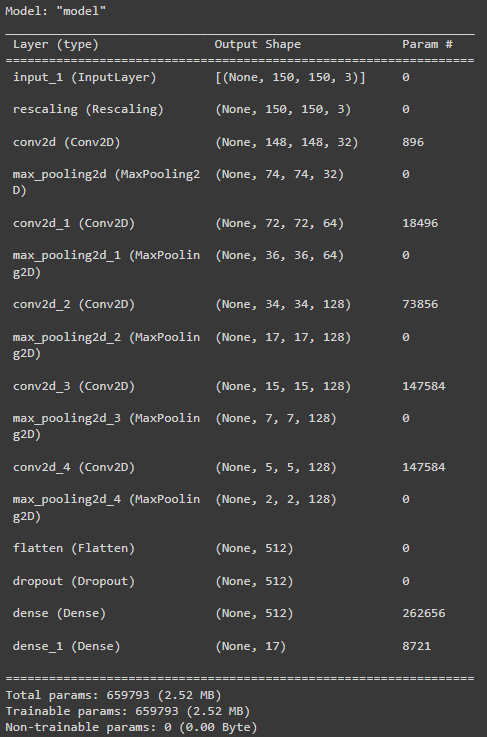

In [70]:
inputs = keras.Input(shape=(150,150,3))
x=layers.Rescaling(1./255)(inputs)
x=layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Flatten()(x)
x= layers.Dropout(0.5)(x)
x=layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
outputs = layers.Dense(14, activation='softmax')(x)
model=keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 rescaling_6 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                     

Lets visualize the last output:


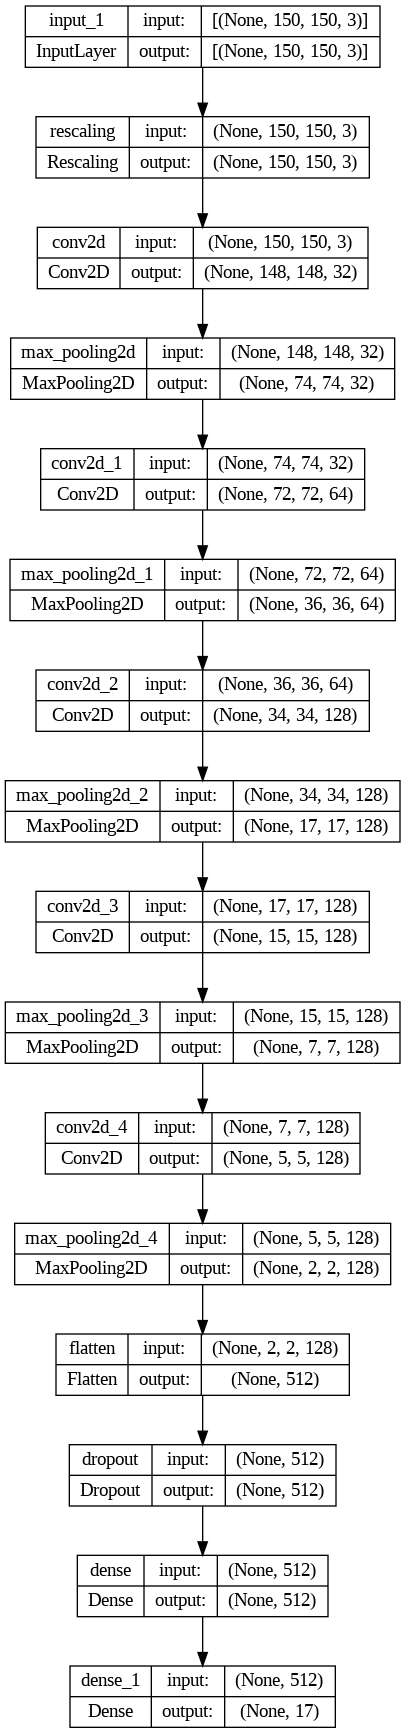

The next line of code is commented out because its output is the last image.

In [ ]:
#model = Model(inputs=inputs, outputs=outputs)
#plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [71]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])
history=model.fit(amostra_treino, epochs=40, validation_data=amostra_validacao)

Epoch 1/40
432/432 [==============================] - 64s 143ms/step - loss: 2.4178 - acc: 0.3305 - val_loss: 2.2298 - val_acc: 0.3798
Epoch 2/40
432/432 [==============================] - 62s 142ms/step - loss: 2.1644 - acc: 0.4090 - val_loss: 1.9988 - val_acc: 0.4557
Epoch 3/40
432/432 [==============================] - 62s 142ms/step - loss: 1.9799 - acc: 0.4604 - val_loss: 1.8649 - val_acc: 0.4880
Epoch 4/40
432/432 [==============================] - 62s 143ms/step - loss: 1.8387 - acc: 0.4945 - val_loss: 1.7162 - val_acc: 0.5255
Epoch 5/40
432/432 [==============================] - 62s 141ms/step - loss: 1.7295 - acc: 0.5196 - val_loss: 1.6249 - val_acc: 0.5454
Epoch 6/40
432/432 [==============================] - 62s 142ms/step - loss: 1.6484 - acc: 0.5421 - val_loss: 1.5462 - val_acc: 0.5710
Epoch 7/40
432/432 [==============================] - 62s 143ms/step - loss: 1.5805 - acc: 0.5561 - val_loss: 1.4969 - val_acc: 0.5758
Epoch 8/40
432/432 [==============================] - 6

So the last set of params origened the follow history

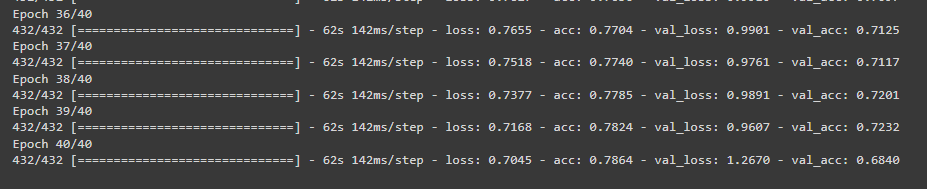

Let's save our model. We will add comments to prevent accidentally overwriting the previous one.

In [72]:
#model.save('/content/drive/MyDrive/cardatset_CatCross_RMSprop.h5')

In [73]:
keras.models.load_model('/content/drive/MyDrive/cardatset_CatCross_RMSprop.h5')
val_loss, val_acc = model.evaluate(amostra_validacao)
print('val_acc:', round(val_acc,2)*100)
print('val_loss:', round(val_loss,2))

217/217 [==============================] - 21s 92ms/step - loss: 1.0197 - acc: 0.7184
val_acc: 72.0
val_loss: 1.02


Lets graph the last model

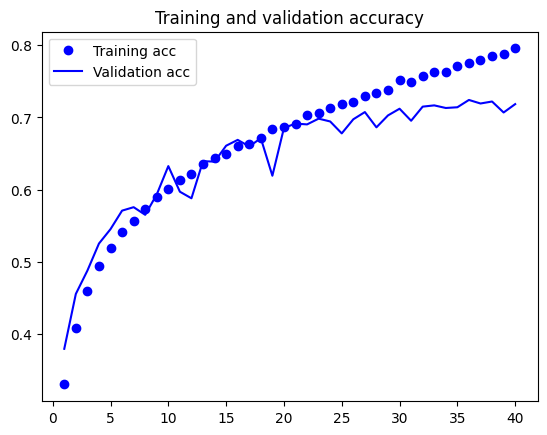

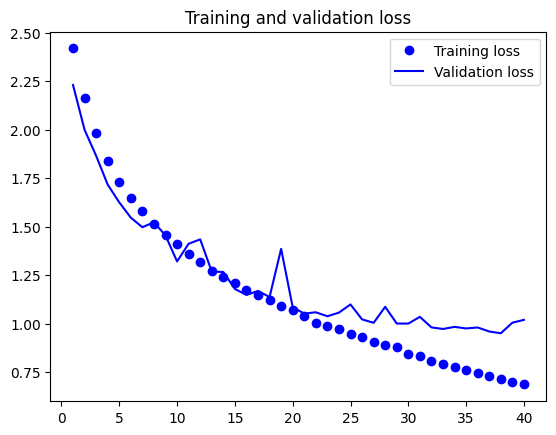

In [74]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Lets' analise the previous grafhs

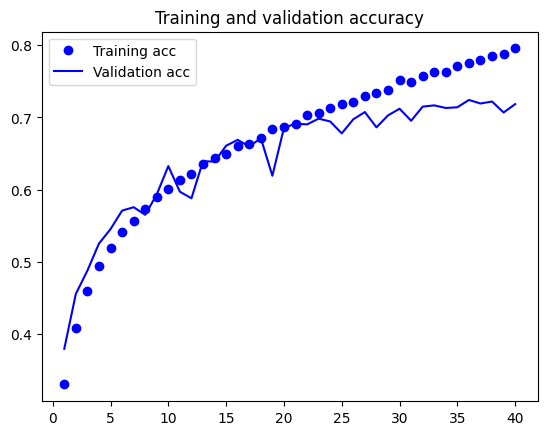

From general trend we can see that both training and validation accuracies increase over time. Up to approximately the 10th epoch, both curves rise similarly, after that, the training accuracy continues to increase steadily, while the validation accuracy oscillates more, suggesting a potential beginning of overfitting, although it is not pronounced.

About the training accuracy curve, the training accuracy increases steadily, suggesting that the model is learning well from the training data.
The validation accuracy also increases, with some oscillations, which is normal.

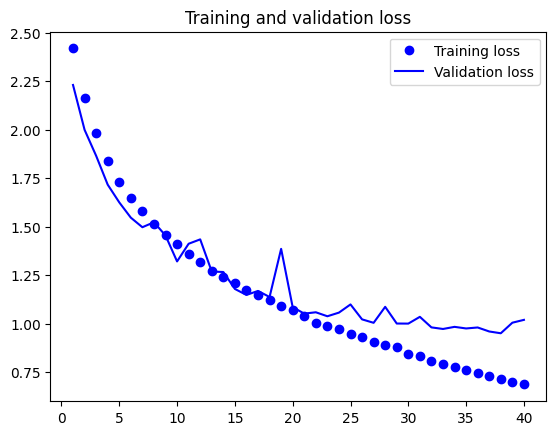

From the general trend, both training and validation losses decrease over time, indicating that the model is learning and improving. We can see that the training loss curve starts high and continuously decreases, suggesting that the model is fitting well to the training data. Simultaneously, the validation loss also decreases but with some oscillation, which is expected due to the variability in the validation data. The validation loss closely follows the training loss, which is a good sign that there is no significant overfitting.

There is no significant divergence between the training and validation curves, which is a good sign. However, the oscillation in validation accuracy after the 10th epoch may indicate the beginning of overfitting. We can use techniques such as regularization, dataaugmetation, or early stopping methods, to further improve the model's generalization.

#Loss Fuction#
So lets try 2 diferent loss function we will try:

*   [categorical_focal_crossentropy](https://neptune.ai/blog/keras-loss-functions)
*   [KLDivergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)


##Categorical Focal Crossentropy##
We can define it in the matemathical point of view in the next formula

$\text{CategoricalCrossentropy} = - \sum_{i=1}^{N} \sum_{j=1}^{C} y_{ij} .\log(\hat{y}_{ij})$


*   $C$ It is the number of our classes (14).
*   $y_{ij}$ It is the classification score for the i-th sample and the j-th class (one-hot encoded, so $y_{ij}$ It is 1 for the correct vehicle and 0 for the other vehicles).
*   $\hat{y}_{ij}$ The predicted probability by our neural network for the i-th sample and the j-th class.
We can view a detailed explanation [here](https://www.youtube.com/watch?v=AqqbZmuPu60&t=19s)




In [17]:
model.compile(loss='categorical_focal_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])
history1=model.fit(amostra_treino, epochs=40, validation_data=amostra_validacao)

Epoch 1/40
432/432 [==============================] - 64s 144ms/step - loss: 0.1475 - acc: 0.7912 - val_loss: 0.2024 - val_acc: 0.7041
Epoch 2/40
432/432 [==============================] - 63s 143ms/step - loss: 0.1346 - acc: 0.7940 - val_loss: 0.1835 - val_acc: 0.7214
Epoch 3/40
432/432 [==============================] - 62s 142ms/step - loss: 0.1253 - acc: 0.7989 - val_loss: 0.1770 - val_acc: 0.7235
Epoch 4/40
432/432 [==============================] - 62s 142ms/step - loss: 0.1170 - acc: 0.7980 - val_loss: 0.1732 - val_acc: 0.7268
Epoch 5/40
432/432 [==============================] - 62s 142ms/step - loss: 0.1109 - acc: 0.7995 - val_loss: 0.1637 - val_acc: 0.7248
Epoch 6/40
432/432 [==============================] - 62s 143ms/step - loss: 0.1080 - acc: 0.8023 - val_loss: 0.1630 - val_acc: 0.7219
Epoch 7/40
432/432 [==============================] - 62s 143ms/step - loss: 0.1049 - acc: 0.7995 - val_loss: 0.1626 - val_acc: 0.7204
Epoch 8/40
432/432 [==============================] - 6

The last test give us the follow
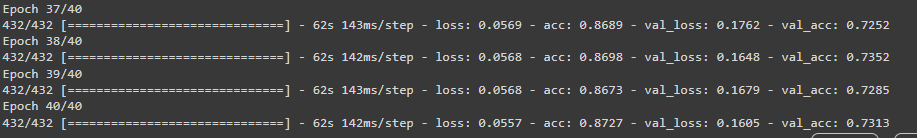

Lets save our modelo with de Categorical Focal Crossentropy Loss

In [18]:
#model.save('/content/drive/MyDrive/cardatset_CatfocalCross_RMSprop.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
keras.models.load_model('/content/drive/MyDrive/cardatset_CatfocalCross_RMSprop.h5')
val_loss, val_acc = model.evaluate(amostra_validacao)
print('val_acc:', round(val_acc,2)*100)
print('val_loss:', round(val_loss,2))

217/217 [==============================] - 21s 92ms/step - loss: 0.1605 - acc: 0.7313
val_acc: 73.0
val_loss: 0.16


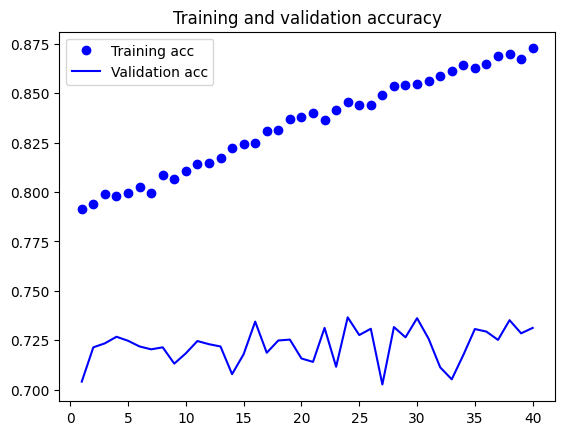

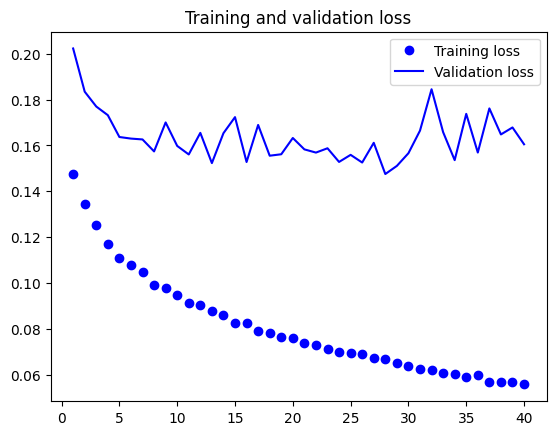

In [20]:
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()



From general trend we can confirm that training accuracy consistently increases over time, indicating that the model is learning well from the training data.
In the other hand the validation accuracy shows a stable trend but with significant oscillations, suggesting the model is having difficulty generalizing to the validation data.

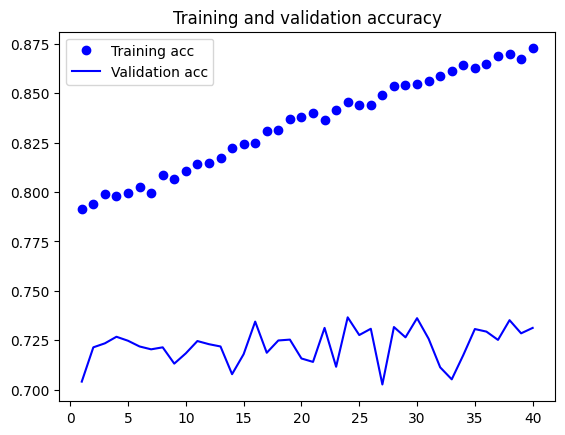

Training Accuracy Curve training accuracy starts around 0.80 and steadily increases to approximately 0.875, indicating that the model is fitting better to the training data when comparate with validation accuracy that fluctuates around 0.70 to 0.73, without a clear upward trend, indicating that the model is not improving its performance on the validation data and may be suffering from overfitting.
It seems that the growing gap between the training and validation accuracy curves suggests that the model is memorizing the training data but is not generalizing well to the validation data.

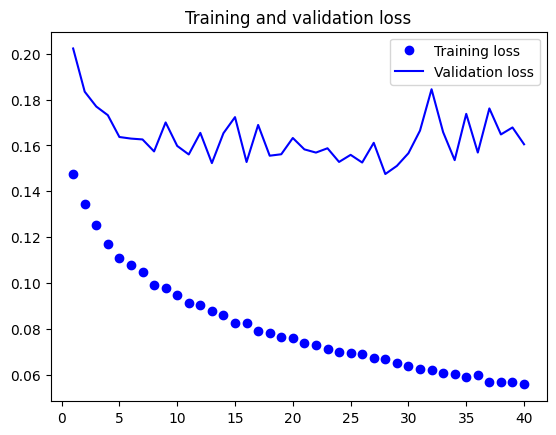


When we compare the loss we can see that the training loss consistently decreases over time, indicating that the model is learning to minimize error on the training data. But the oposite happens with the validation loss that shows a stable trend but with significant oscillations, reflecting the model's difficulty in generalizing.
The training loss curve starts high and continuously decreases to approximately 0.06, indicating that the model is fitting well to the training data. The validation loss fluctuates around 0.12 to 0.16, without a clear downward trend, which reinforces the possibility of overfitting.
The growing gap between the training and validation loss curves suggests that the model is overfitting to the training data, without corresponding improvement on the validation data.
The graphs clearly indicate signs of overfitting, where the model shows high accuracy on the training data but does not improve its accuracy on the validation data. The constant validation loss and oscillation in validation accuracy support this.
The recomendations are the same from the last loss fuction.

So let's go now for the other loss fuction the

##KL Divergence##

$KL Divergence = D_{\text{KL}}(P \parallel Q) = \sum_{x} P(x) \log \frac{P(x)}{Q(x)}$

where:

*   $P(x)$ is the true probability distribution.
*   $Q(x)$ is the approximate probability distribution.




In [34]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
               loss=keras.losses.KLDivergence(reduction="sum_over_batch_size", name="kl_divergence"),
               metrics=['accuracy'])
history2=model.fit(amostra_treino, epochs=40, validation_data=amostra_validacao)

Epoch 1/40
432/432 [==============================] - 64s 144ms/step - loss: -8.9809e-06 - accuracy: 0.0598 - val_loss: -9.4453e-06 - val_accuracy: 0.0450
Epoch 2/40
432/432 [==============================] - 62s 143ms/step - loss: -9.9618e-06 - accuracy: 0.0571 - val_loss: -9.8113e-06 - val_accuracy: 0.0539
Epoch 3/40
432/432 [==============================] - 62s 142ms/step - loss: -1.0393e-05 - accuracy: 0.0565 - val_loss: -1.0655e-05 - val_accuracy: 0.0528
Epoch 4/40
432/432 [==============================] - 62s 141ms/step - loss: -1.0316e-05 - accuracy: 0.0528 - val_loss: -1.1001e-05 - val_accuracy: 0.0502
Epoch 5/40
432/432 [==============================] - 62s 142ms/step - loss: -1.0740e-05 - accuracy: 0.0601 - val_loss: -1.0867e-05 - val_accuracy: 0.0502
Epoch 6/40
432/432 [==============================] - 62s 143ms/step - loss: -9.8545e-06 - accuracy: 0.0480 - val_loss: -1.0812e-05 - val_accuracy: 0.0570
Epoch 7/40
432/432 [==============================] - 62s 143ms/step -

We sucessfuly train our model with KLDivergences and this is part off our output

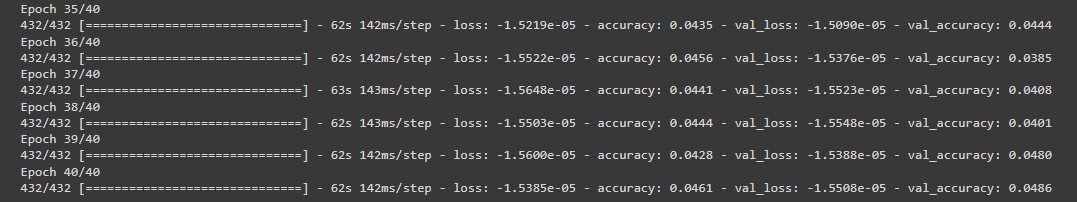

We can see that our metrics are very poor, indicating that the loss function is probably not the best for our problem.

lets save our model

In [36]:
#model.save('/content/drive/MyDrive/cardatset_KLDivergences_RMSprop.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
keras.models.load_model('/content/drive/MyDrive/cardatset_KLDivergences_RMSprop.h5')
val_loss, val_acc = model.evaluate(amostra_validacao)
print('val_acc:', round(val_acc,2)*100)
print('val_loss:', round(val_loss,2))

217/217 [==============================] - 21s 92ms/step - loss: -1.5508e-05 - accuracy: 0.0486
val_acc: 5.0
val_loss: -0.0


Now, let's see our model graph.

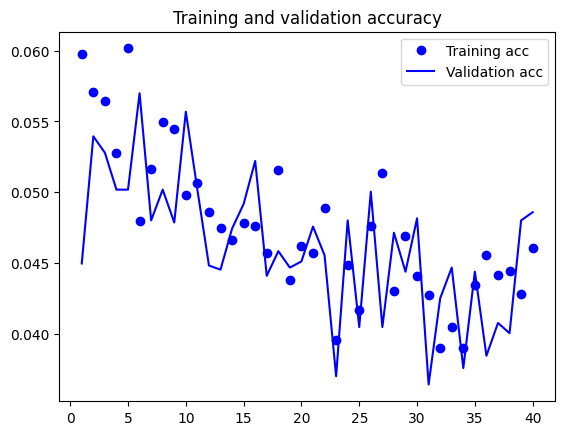

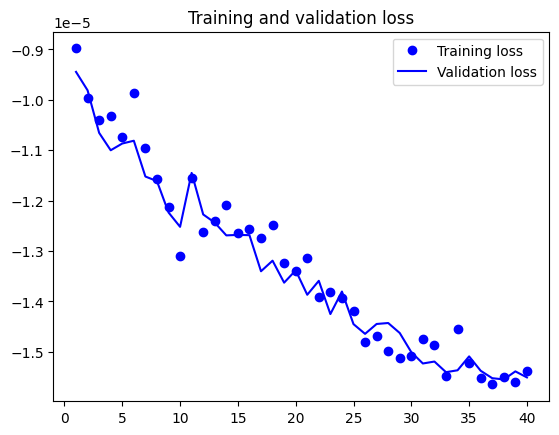

In [40]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Let's analyze the last two graphs, the first one from accuracy metrics:

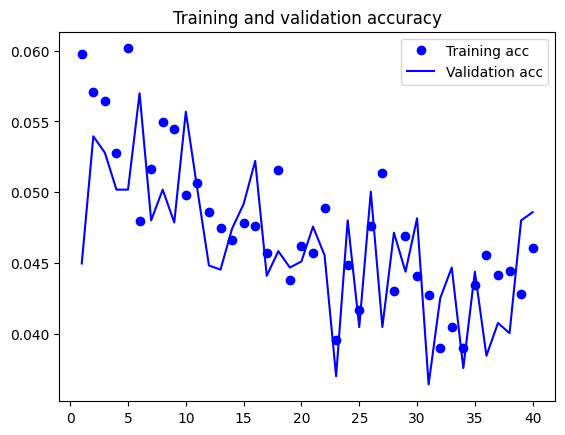

from the general trend both training and validation accuracies fluctuate significantly, indicating instability in the model's learning process.
The validation accuracy mirrors the fluctuations seen in the training accuracy, indicating that the model's performance on unseen data is similarly unstable.
The validation accuracy peaks at around 0.06 but frequently drops below 0.05.
The oscillations suggest that the model is not generalizing well to the validation data and may be overfitting to the training data.
The significant fluctuations in both training and validation accuracies indicate that the model is not converging properly.
This instability could be due to several factors, such as an inappropriate learning rate, insufficient regularization, or an overly complex model for the given data.

Now about the loss graph we can see that

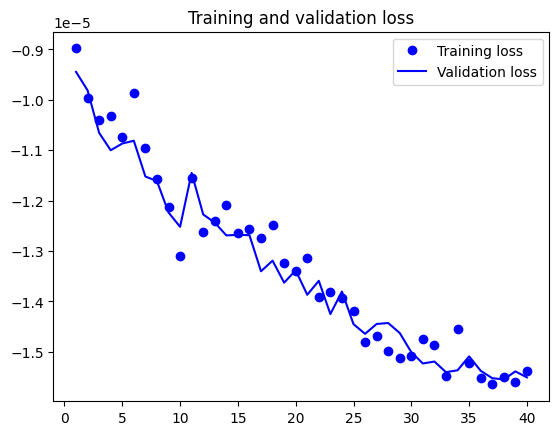

From general trend

The training loss starts high, at around $-0.9 \times 10^{-5}$
, and steadily decreases to approximately $-1.5 \times 10^{-5}$.
The continuous decrease in training loss suggests that the model is fitting better to the training data as epochs progress.
The validation loss follows a similar downward trend as the training loss
The validation loss curve closely follows the training loss curve with minor fluctuations, which is expected due to variability in the validation data.


So we can summarize the last codes with the next table:

| <center>**Feature**</center>|<center>**KL Divergence**</center>|<center>**Categorical Focal Crossentropy**</center>|<center>**Categorical Crossentropy**</center>|
|--------------------------------|------------------------------------------------------------|------------------------------------------------------------------|-------------------------------------------------------------|
|Accuracy|<center>5%</center> | <center>73%</center>|<center>68%</center>|
|Loss|<center>0</center>|<center>16</center>|<center>1.27</center>|
|Overfitting|<center>No</center> |<center>Yes</center>|<center>No<center>|

We decided to continue with the Categorical Crossentropy, because:

It has a high accuracy (68%) that is close to the accuracy of Categorical Focal Crossentropy (73%).
It does not exhibit overfitting, which is crucial to ensure that the model can generalize well to new data.

And so we fullfill the next point
- [X] ~~At least two distinct loss functions should be tried;~~

#Optimizers#

- [X] At least two distinct optimizers should be tried;

Now about the optimizers we decided to use:

*   [Adam](https://keras.io/api/optimizers/adam/)
*   [SGD](https://keras.io/api/optimizers/sgd/)

##Adam##

One of the principals caracteristics from adam it is that it uses the exponentially weighted moving averages also known as leaky averages, to obtain an estimate of the first moment and the second moment of the gradient. In other words, it uses the state variables:

$\mathbf{v}_t \leftarrow \beta_1 \mathbf{v}_{t-1} + (1 - \beta_1) \mathbf{g}_t$

$\mathbf{s}_t \leftarrow \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2$

We can see the rest of the explantion [here](https://pt.d2l.ai/chapter_optimization/adam.html)


In [41]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['acc'])
historyadam=model.fit(amostra_treino, epochs=40, validation_data=amostra_validacao)

Epoch 1/40
432/432 [==============================] - 65s 143ms/step - loss: 1.3888 - acc: 0.5634 - val_loss: 1.0916 - val_acc: 0.6488
Epoch 2/40
432/432 [==============================] - 63s 145ms/step - loss: 0.9544 - acc: 0.6844 - val_loss: 0.9684 - val_acc: 0.6919
Epoch 3/40
432/432 [==============================] - 63s 145ms/step - loss: 0.8136 - acc: 0.7276 - val_loss: 0.9059 - val_acc: 0.7122
Epoch 4/40
432/432 [==============================] - 63s 143ms/step - loss: 0.7285 - acc: 0.7531 - val_loss: 0.8947 - val_acc: 0.7185
Epoch 5/40
432/432 [==============================] - 62s 142ms/step - loss: 0.6600 - acc: 0.7750 - val_loss: 0.9322 - val_acc: 0.7109
Epoch 6/40
432/432 [==============================] - 63s 144ms/step - loss: 0.6086 - acc: 0.7911 - val_loss: 0.8682 - val_acc: 0.7292
Epoch 7/40
432/432 [==============================] - 63s 145ms/step - loss: 0.5587 - acc: 0.8075 - val_loss: 0.8908 - val_acc: 0.7198
Epoch 8/40
432/432 [==============================] - 6

In [42]:
#model.save('/content/drive/MyDrive/cardatset_categorical_crossentrop_ADAM.h5')

The result output for our model seems promising.

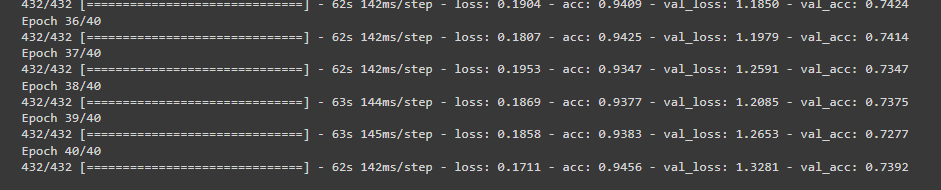

In [43]:
keras.models.load_model('/content/drive/MyDrive/cardatset_categorical_crossentrop_ADAM.h5')
val_loss, val_acc = model.evaluate(amostra_validacao)
print('val_acc:', round(val_acc,2)*100)
print('val_loss:', round(val_loss,2))

217/217 [==============================] - 21s 93ms/step - loss: 1.3281 - acc: 0.7392
val_acc: 74.0
val_loss: 1.33


Now it's time t go to our second optimizer the SGD

##SGD#

We should mention that the stochastic gradient $\nabla f_i(\mathbf{x})$ is the unbiased estimate of the gradient $\nabla f(\mathbf{x})$.

$\mathbb{E}_i \nabla f_i(\mathbf{x}) = \frac{1}{n} \sum_{i=1}^n \nabla f_i(\mathbf{x}) = \nabla f(\mathbf{x})$

We can see more at [here](https://pt.d2l.ai/chapter_optimization/sgd.html)

In [44]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4), metrics=['acc'])
historysgd=model.fit(amostra_treino, epochs=40, validation_data=amostra_validacao)

Epoch 1/40
432/432 [==============================] - 64s 143ms/step - loss: 0.1415 - acc: 0.9560 - val_loss: 1.2528 - val_acc: 0.7463
Epoch 2/40
432/432 [==============================] - 63s 143ms/step - loss: 0.1287 - acc: 0.9614 - val_loss: 1.2535 - val_acc: 0.7460
Epoch 3/40
432/432 [==============================] - 62s 143ms/step - loss: 0.1237 - acc: 0.9635 - val_loss: 1.2560 - val_acc: 0.7449
Epoch 4/40
432/432 [==============================] - 62s 143ms/step - loss: 0.1300 - acc: 0.9608 - val_loss: 1.2442 - val_acc: 0.7467
Epoch 5/40
432/432 [==============================] - 62s 143ms/step - loss: 0.1209 - acc: 0.9655 - val_loss: 1.2551 - val_acc: 0.7459
Epoch 6/40
432/432 [==============================] - 62s 142ms/step - loss: 0.1169 - acc: 0.9653 - val_loss: 1.2542 - val_acc: 0.7463
Epoch 7/40
432/432 [==============================] - 62s 143ms/step - loss: 0.1186 - acc: 0.9643 - val_loss: 1.2588 - val_acc: 0.7469
Epoch 8/40
432/432 [==============================] - 6

In [45]:
#model.save('/content/drive/MyDrive/cardatset_categorical_crossentrop_SGD.h5')

In [46]:
keras.models.load_model('/content/drive/MyDrive/cardatset_categorical_crossentrop_SGD.h5')
val_loss, val_acc = model.evaluate(amostra_validacao)
print('val_acc:', round(val_acc,2)*100)
print('val_loss:', round(val_loss,2))

217/217 [==============================] - 21s 91ms/step - loss: 1.3020 - acc: 0.7463
val_acc: 75.0
val_loss: 1.3


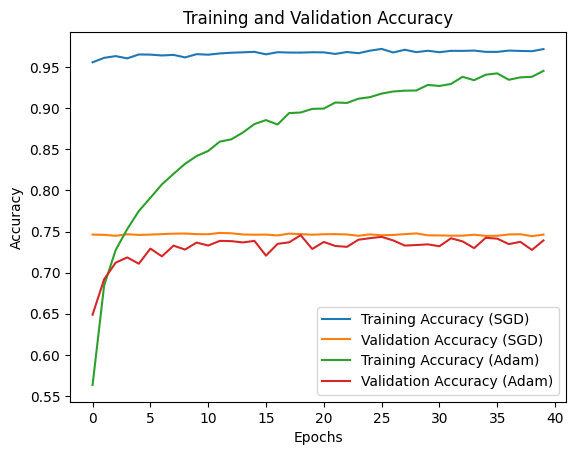

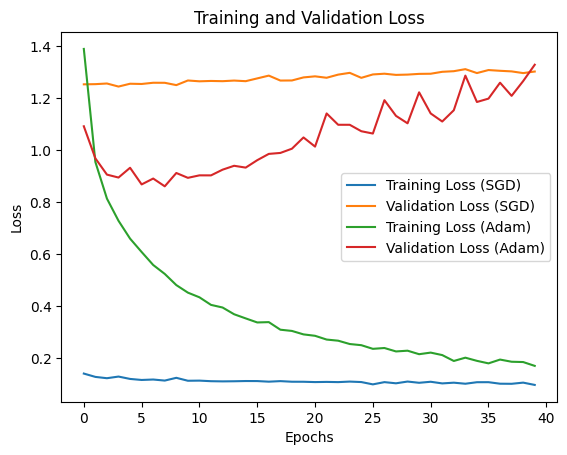

In [47]:
plt.plot(historysgd.history['acc'], label='Training Accuracy (SGD)')
plt.plot(historysgd.history['val_acc'], label='Validation Accuracy (SGD)')
plt.plot(historyadam.history['acc'], label='Training Accuracy (Adam)')
plt.plot(historyadam.history['val_acc'], label='Validation Accuracy (Adam)')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(historysgd.history['loss'], label='Training Loss (SGD)')
plt.plot(historysgd.history['val_loss'], label='Validation Loss (SGD)')
plt.plot(historyadam.history['loss'], label='Training Loss (Adam)')
plt.plot(historyadam.history['val_loss'], label='Validation Loss (Adam)')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

So let's analize the follow graph

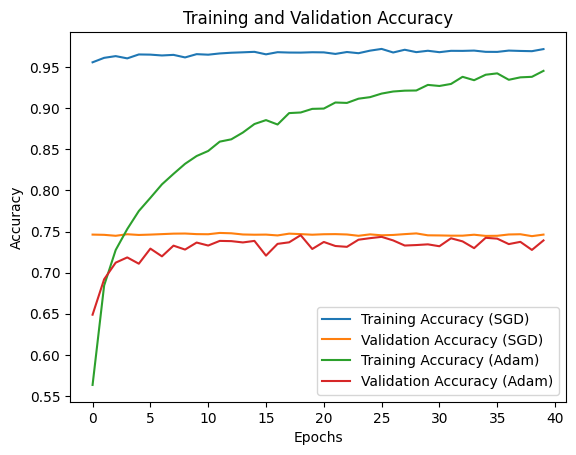

From SGD we can see that the training accuracy starts high and remains consistently above 95%, this indicates that the model is fitting the training data extremely well with the SGD optimizer.
But forthe other hand the validation accuracy for SGD starts around 75% and remains flat throughout the training process. This suggests that the model is not improving its performance on the validation data, indicating overfitting.

In the case of the ADAM optimizer the training accuracy starts lower and gradually increases, reaching approximately 92% by the end of the 40 epochs.
This gradual increase suggests that the Adam optimizer is effectively learning and fitting the training data over time. The validation accuracy for Adam starts around 65% and shows a slight increase to about 75%, with some fluctuations that indicates that while the model is learning, it might be struggling to generalize, although not as severely as with SGD.

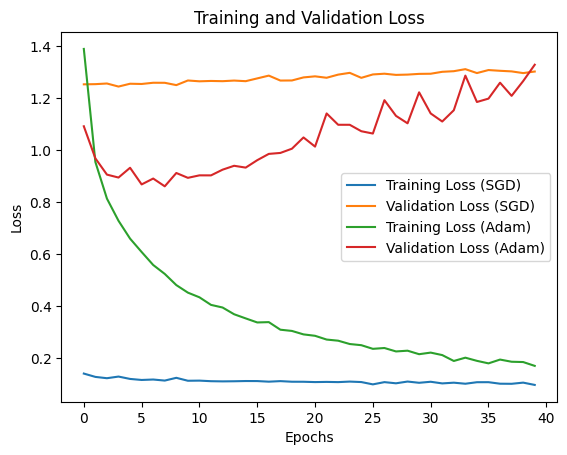

When we analize the loss graph we see that from SGD the training loss starts very low and remains low, indicating that the model is fitting the training data very well.howver the minimal change suggests that the model is not learning anything new, which is consistent with overfitting.
The validation loss for SGD remains relatively high and flat, indicating that the model is not generalizing well to the validation data. This supports the observation of overfitting from the accuracy graph.
The training loss for Adam starts higher but decreases steadily, reaching a much lower value by the end of the our 40 epochs.
This consistent decrease indicates effective learning from the training data.
The validation loss for Adam starts higher and decreases, but not as significantly as the training loss. It exhibits some fluctuations but generally trends downwards. This suggests that the model with Adam is generalizing better than with SGD, though there is still room for improvement.

we decide to continue with the RMSprop because:

Absence of Overfitting: RMSprop does not exhibit overfitting, which is crucial to ensure that the model can generalize well to new data.
Lower Loss: RMSprop has the lowest loss (1.28), indicating that the model is effectively minimizing the loss function.
Moderate Accuracy: Although the accuracy is the lowest (68%), the absence of overfitting and the lower loss compensate for this, especially if stability and generalization are priorities.


So we can summarize the last codes with the next table:

| <center>**Feature**</center>|<center>**Adam**</center>|<center>**SGD**</center>|<center>**RMSprop**</center>|
|--------------------------------|------------------------------------------------------------|------------------------------------------------------------------|-------------------------------------------------------------|
|Accuracy|<center>74%</center>| <center>75%</center>|<center>68%</center>|
|Loss|<center>1.33</center>|<center>1.3</center>|<center>1.28</center>|
|Overfitting|<center>yes</center>|<center>yes</center>|<center>No<center>|

So with that we fullfill the step
- [X] ~~At least two distinct optimizers should be tried~~;

#Regularization techniques#
- [X] At least two distinct regularization techniques should be tried;

So for the above point we gonna use the:

*   [L1L2 class](https://keras.io/2.15/api/layers/regularizers/)
*   [L1 class](https://keras.io/2.15/api/layers/regularizers/)

So let's start with the regularizer that applies both L1 and L2 regularization penalties.

The L1 regularization penalty is computed as: $loss = l1 * reducesum(abs(x))$
and the The L2 regularization penalty is computed as $loss = l2 * reducesum(square(x))$




In [48]:
inputs = keras.Input(shape=(150,150,3))
x=layers.Rescaling(1./255)(inputs)
x=layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Flatten()(x)
x= layers.Dropout(0.5)(x)
x=layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.L1L2(0.001))(x)
outputs = layers.Dense(14, activation='sigmoid')(x)
model=keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])
historyL1l2=model.fit(amostra_treino, epochs=40, validation_data=amostra_validacao)

Epoch 1/40
432/432 [==============================] - 64s 142ms/step - loss: 8.8397 - acc: 0.3320 - val_loss: 6.3045 - val_acc: 0.4060
Epoch 2/40
432/432 [==============================] - 64s 147ms/step - loss: 4.9675 - acc: 0.4031 - val_loss: 3.9484 - val_acc: 0.4504
Epoch 3/40
432/432 [==============================] - 63s 145ms/step - loss: 3.5077 - acc: 0.4513 - val_loss: 3.0557 - val_acc: 0.4811
Epoch 4/40
432/432 [==============================] - 63s 145ms/step - loss: 2.8021 - acc: 0.4829 - val_loss: 2.5282 - val_acc: 0.4918
Epoch 5/40
432/432 [==============================] - 63s 144ms/step - loss: 2.3758 - acc: 0.5008 - val_loss: 2.1937 - val_acc: 0.5103
Epoch 6/40
432/432 [==============================] - 63s 144ms/step - loss: 2.1049 - acc: 0.5184 - val_loss: 2.0146 - val_acc: 0.5009
Epoch 7/40
432/432 [==============================] - 63s 144ms/step - loss: 1.9164 - acc: 0.5294 - val_loss: 1.8352 - val_acc: 0.5518
Epoch 8/40
432/432 [==============================] - 6

In [49]:
#model.save('/content/drive/MyDrive/cardatset_categorical_crossentrop_RMSprop_L1L2.h5')

the output was

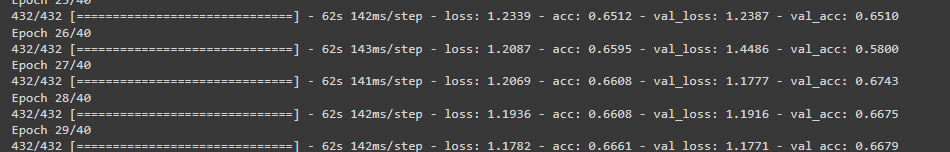

In [50]:
keras.models.load_model('/content/drive/MyDrive/cardatset_categorical_crossentrop_RMSprop_L1L2.h5')
val_loss, val_acc = model.evaluate(amostra_validacao)
print('val_acc:', round(val_acc,2)*100)
print('val_loss:', round(val_loss,2))

217/217 [==============================] - 21s 92ms/step - loss: 1.1057 - acc: 0.6951
val_acc: 70.0
val_loss: 1.11


Let's go now to a regularizer that applies only L1 regularization penalty, just to remember the L1 regularization penalty is computed as: $loss = l1 * reducesum(abs(x))$

In [51]:
inputs = keras.Input(shape=(150,150,3))
x=layers.Rescaling(1./255)(inputs)
x=layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Flatten()(x)
x= layers.Dropout(0.5)(x)
x=layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.L1(0.001))(x)
outputs = layers.Dense(14, activation='sigmoid')(x)
model=keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])
historyL1=model.fit(amostra_treino, epochs=40, validation_data=amostra_validacao)

Epoch 1/40
432/432 [==============================] - 64s 143ms/step - loss: 8.6008 - acc: 0.3197 - val_loss: 5.8600 - val_acc: 0.3717
Epoch 2/40
432/432 [==============================] - 63s 143ms/step - loss: 4.4899 - acc: 0.3801 - val_loss: 3.5721 - val_acc: 0.4160
Epoch 3/40
432/432 [==============================] - 62s 142ms/step - loss: 3.1821 - acc: 0.4303 - val_loss: 2.8254 - val_acc: 0.4549
Epoch 4/40
432/432 [==============================] - 62s 142ms/step - loss: 2.6273 - acc: 0.4598 - val_loss: 2.4209 - val_acc: 0.4745
Epoch 5/40
432/432 [==============================] - 62s 142ms/step - loss: 2.2896 - acc: 0.4880 - val_loss: 2.1153 - val_acc: 0.5045
Epoch 6/40
432/432 [==============================] - 62s 143ms/step - loss: 2.0645 - acc: 0.5024 - val_loss: 1.9593 - val_acc: 0.5088
Epoch 7/40
432/432 [==============================] - 62s 143ms/step - loss: 1.9053 - acc: 0.5177 - val_loss: 1.7855 - val_acc: 0.5325
Epoch 8/40
432/432 [==============================] - 6

In [52]:
#model.save('/content/drive/MyDrive/cardatset_categorical_crossentrop_RMSprop_L1.h5')

the result was

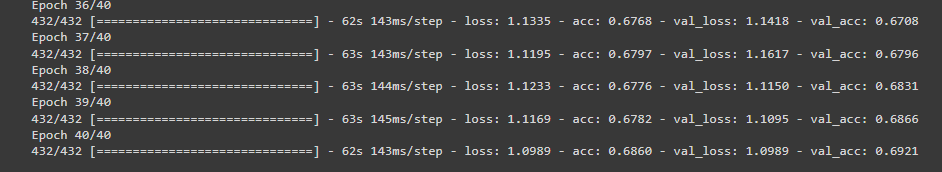


In [53]:
keras.models.load_model('/content/drive/MyDrive/cardatset_categorical_crossentrop_RMSprop_L1.h5')
val_loss, val_acc = model.evaluate(amostra_validacao)
print('val_acc:', round(val_acc,2)*100)
print('val_loss:', round(val_loss,2))

217/217 [==============================] - 21s 94ms/step - loss: 1.0989 - acc: 0.6921
val_acc: 69.0
val_loss: 1.1


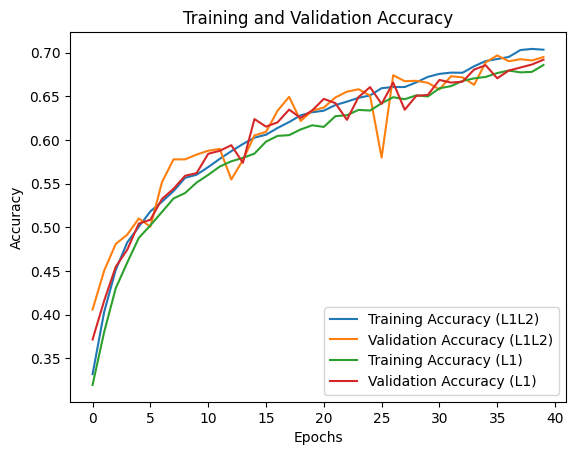

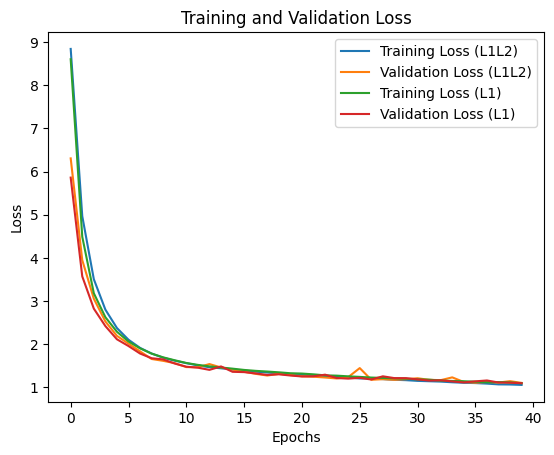

In [54]:
plt.plot(historyL1l2.history['acc'], label='Training Accuracy (L1L2)')
plt.plot(historyL1l2.history['val_acc'], label='Validation Accuracy (L1L2)')
plt.plot(historyL1.history['acc'], label='Training Accuracy (L1)')
plt.plot(historyL1.history['val_acc'], label='Validation Accuracy (L1)')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(historyL1l2.history['loss'], label='Training Loss (L1L2)')
plt.plot(historyL1l2.history['val_loss'], label='Validation Loss (L1L2)')
plt.plot(historyL1.history['loss'], label='Training Loss (L1)')
plt.plot(historyL1.history['val_loss'], label='Validation Loss (L1)')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

So let's compare the last graph

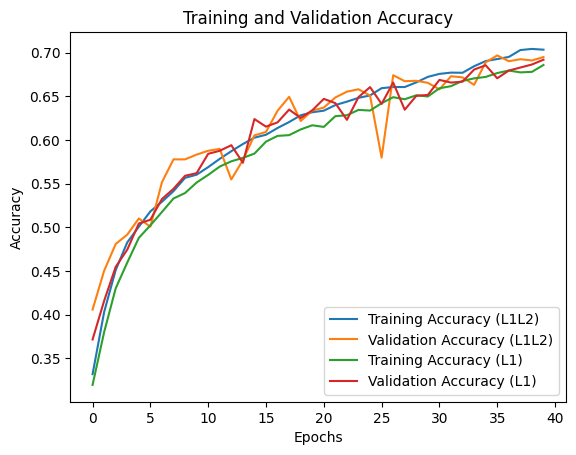

The training accuracy for the combined L1L2 regularization starts at under 0.35 and increases steadily to near 0.70.
The validation accuracy for the combined L1L2 regularization shows a similar trend, indicating that the model is learning effectively with this regularization method.
The same happens when analise the the training accuracy with L1 regularization that also starts at about 0.35 but this only increases to about 0.67.
The validation accuracy for L1 shows some fluctuation but generally follows the training accuracy, indicating good generalization with slight instability.

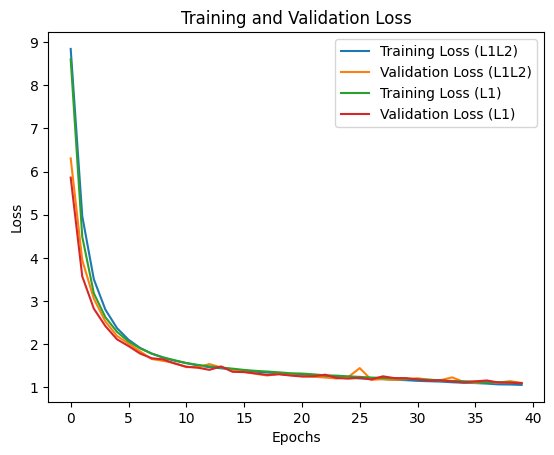

For the training loss when we analise the combined L1L2 regularization  we see that it starts high and decreases sharply, stabilizing around 1.
The validation loss for the combined L1L2 regularization follows a similar pattern, suggesting effective minimization of the loss function.
The training loss with L1 regularization shows a similar sharp decrease and stabilization around 1. The validation loss for L1 regularization is slightly higher than L1L2, but still shows good convergence.

So we can summarize the last codes with the next table:

| <center>**Feature**</center>|<center>**L1L2**</center>|<center>**L1**</center>|<center>**L2**</center>|
|--------------------------------|------------------------------------------------------------|------------------------------------------------------------------|-------------------------------------------------------------|
|Accuracy|<center>70%</center>| <center>69%</center>|<center>68%</center>|
|Loss|<center>1.11</center>|<center>1.1</center>|<center>1.28</center>|
|Overfitting|<center>no</center>|<center>no</center>|<center>No<center>|

we decided to change to de L1L2 regularization

- [X] ~~At least two distinct regularization techniques should be tried;~~

Let's go the the lasts point of our work

- [X] Model S should be trained both with and without data augmentation;


Let's start to train the model without data augmentation


In [75]:
data_augmentation = keras.Sequential(
  [
    keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=None),
    keras.layers.RandomCrop(100, 100, seed=None, name=None),
    keras.layers.RandomTranslation(0.2,0.2,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    keras.layers.RandomRotation(0.2,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    keras.layers.RandomZoom(0.2,width_factor=None,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    keras.layers.RandomContrast(0.2, seed=None),
    keras.layers.RandomBrightness(0.2, value_range=(0, 255), seed=None)
  ]
)

Up to this point, we haven't changed the number of epochs because we wanted a fast process. However, as we approach the end of the work, we will start working with more epochs.

We decide to continue with the:


*   Loss: *categorical crossentropy*
*   Optimizer: [*RMSprop*](https://medium.com/thedeephub/what-is-rmsprop-0f54effc47e4)
*   Regularizers: L1L2


In [76]:
inputs = keras.Input(shape=(150,150,3))
x = data_augmentation(inputs)
x=layers.Rescaling(1./255)(x)
x=layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Flatten()(x)
x= layers.Dropout(0.5)(x)
x=layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.L1L2(0.001))(x)
outputs = layers.Dense(14, activation='softmax')(x)
model=keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])
historydataagu=model.fit(amostra_treino, epochs=50, validation_data=amostra_validacao)

Epoch 1/50
432/432 [==============================] - 65s 143ms/step - loss: 4.3533 - acc: 0.3069 - val_loss: 3.5328 - val_acc: 0.3390
Epoch 2/50
432/432 [==============================] - 63s 144ms/step - loss: 3.1068 - acc: 0.3148 - val_loss: 2.8192 - val_acc: 0.2871
Epoch 3/50
432/432 [==============================] - 62s 143ms/step - loss: 2.6212 - acc: 0.3248 - val_loss: 2.4878 - val_acc: 0.3651
Epoch 4/50
432/432 [==============================] - 62s 142ms/step - loss: 2.4437 - acc: 0.3392 - val_loss: 2.3002 - val_acc: 0.3920
Epoch 5/50
432/432 [==============================] - 62s 142ms/step - loss: 2.3181 - acc: 0.3439 - val_loss: 2.3553 - val_acc: 0.2842
Epoch 6/50
432/432 [==============================] - 62s 142ms/step - loss: 2.2177 - acc: 0.3487 - val_loss: 2.2039 - val_acc: 0.3222
Epoch 7/50
432/432 [==============================] - 62s 143ms/step - loss: 2.1428 - acc: 0.3502 - val_loss: 2.2388 - val_acc: 0.2789
Epoch 8/50
432/432 [==============================] - 6

In [77]:
#model.save('/content/drive/MyDrive/cardatset_categorical_crossentrop_RMSprop_L1L2_DA.h5')

the result was

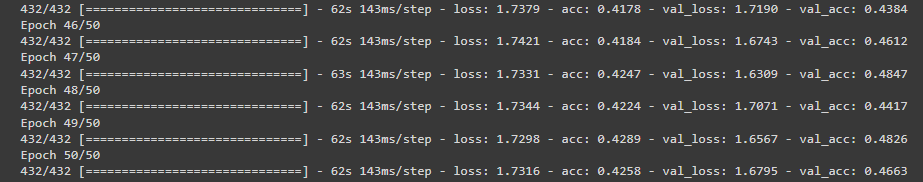



In [78]:
keras.models.load_model('/content/drive/MyDrive/cardatset_categorical_crossentrop_RMSprop_L1L2_DA.h5')
val_loss, val_acc = model.evaluate(amostra_validacao)
print('val_acc:', round(val_acc,2)*100)
print('val_loss:', round(val_loss,2))

217/217 [==============================] - 21s 92ms/step - loss: 1.6614 - acc: 0.4666
val_acc: 47.0
val_loss: 1.66


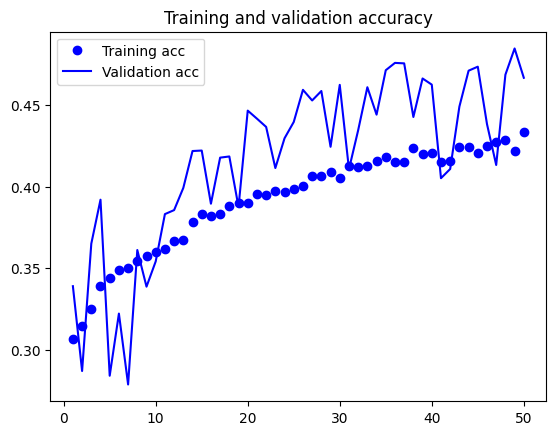

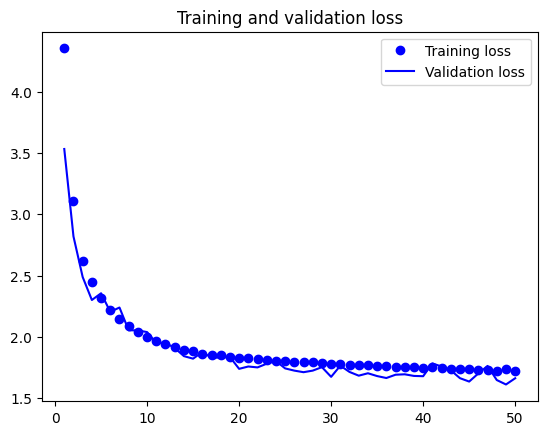

In [79]:
acc = historydataagu.history['acc']
val_acc = historydataagu.history['val_acc']
loss = historydataagu.history['loss']
val_loss = historydataagu.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

So analize the graphs

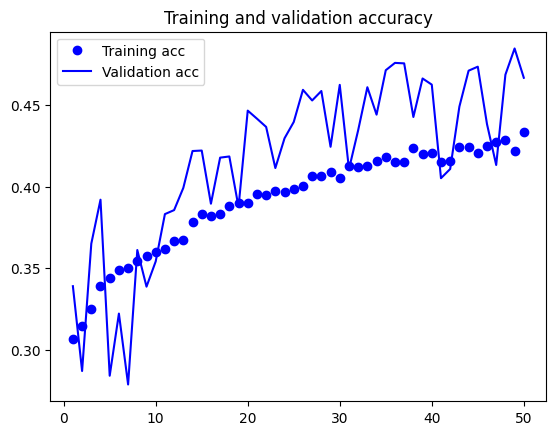

For the accuracy starts at approximately 0.30 and gradually increases to about 0.45 over the course of 50 epochs. The steady increase in training accuracy suggests that the model is learning from the training data, but the progress is slow. Maybe with more epochs or a lower learning rate should raise the metrics, but for the propouse we know for a fact that the best model it will be the one with TL so we just leave that here just for the academic pourpose.
Validation accuracy starts around 0.30 and shows significant fluctuations, but follows an upward trend, reaching about 0.47.
The fluctuations in validation accuracy indicate variability in the model's performance on the validation data, which could be due to the model's sensitivity to the validation data or the learning rate.


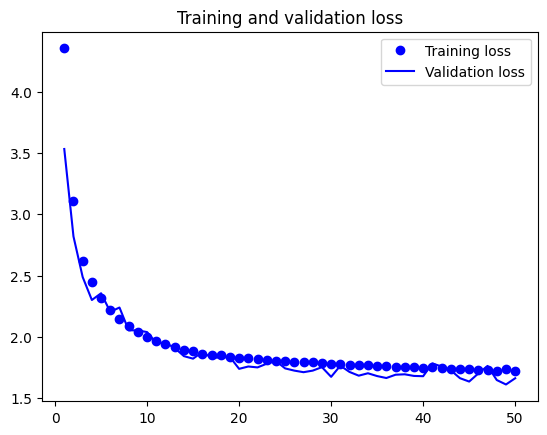

Now the loss starts high at around 4.5 and decreases drastically within the first 10 epochs, stabilizing around 1.8 this rapid decrease in training loss indicates that the model is quickly learning to minimize the loss function on the training data.
Validation loss follows a similar pattern to training loss, starting high and decreasing rapidly, then stabilizing around 1.8. The close tracking of validation loss with training loss suggests that the model is not significantly overfitting, as both losses decrease similarly and stabilize.


The model shows signs of learning and generalization, as both training and validation accuracy increase, and the corresponding losses decrease.
The fluctuations in validation accuracy may indicate that the model is struggling to generalize consistently across all validation examples, which could be addressed with adjustments to the learning rate or additional regularization techniques.

So with the last statement we fullfill the point:

- [X] ~~Model S should be trained both with and without data augmentation;~~

Let's go now to our model with TL tecniches

- [X] Transfer learning (let’s call it Model T) should be tried with both feature extraction and fine tuning;

- [X] Model T should also be trained both with and without data augmentation.

In [80]:
base_model = keras.applications.VGG16(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
base_model.trainable = False
x = base_model(inputs, training=False)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(14, activation='softmax')(x)
model = keras.Model(inputs, outputs)

58889256/58889256 [==============================] - 4s 0us/step


In [81]:
def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = base_model.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

In [82]:
#train_features, train_labels = get_features_and_labels(amostra_treino)
#val_features, val_labels = get_features_and_labels(amostra_validacao)
#test_features, test_labels = get_features_and_labels(amostra_teste)

1/1 [==============================] - 1s 797ms/step


Meanwhile, we built a dense network to handle the classification task.


In [89]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])
historyTLnoDA=model.fit(amostra_treino, epochs=40, validation_data=amostra_validacao)

Epoch 1/40
432/432 [==============================] - 64s 146ms/step - loss: 759.0807 - acc: 0.3902 - val_loss: 624.4324 - val_acc: 0.3928
Epoch 2/40
432/432 [==============================] - 64s 146ms/step - loss: 668.3499 - acc: 0.3980 - val_loss: 659.3063 - val_acc: 0.4030
Epoch 3/40
432/432 [==============================] - 62s 143ms/step - loss: 602.0104 - acc: 0.3928 - val_loss: 925.8781 - val_acc: 0.3360
Epoch 4/40
432/432 [==============================] - 63s 144ms/step - loss: 568.6448 - acc: 0.3969 - val_loss: 1367.0131 - val_acc: 0.1458
Epoch 5/40
432/432 [==============================] - 64s 146ms/step - loss: 519.4037 - acc: 0.3980 - val_loss: 709.0732 - val_acc: 0.3682
Epoch 6/40
432/432 [==============================] - 62s 142ms/step - loss: 476.8826 - acc: 0.3878 - val_loss: 554.7424 - val_acc: 0.3577
Epoch 7/40
432/432 [==============================] - 63s 143ms/step - loss: 453.1863 - acc: 0.3955 - val_loss: 584.9054 - val_acc: 0.3860
Epoch 8/40
432/432 [======

In [91]:
#model.save('/content/drive/MyDrive/cardatset_categorical_crossentrop_RMSprop_L1L2_TLnoDA.h5')

the output was

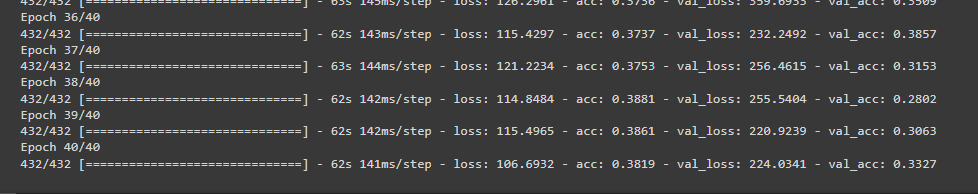

In [92]:
keras.models.load_model('/content/drive/MyDrive/cardatset_categorical_crossentrop_RMSprop_L1L2_TLnoDA.h5')
val_loss, val_acc = model.evaluate(amostra_validacao)
print('val_acc:', round(val_acc,2)*100)
print('val_loss:', round(val_loss,2))

217/217 [==============================] - 21s 91ms/step - loss: 224.0341 - acc: 0.3327
val_acc: 33.0
val_loss: 224.03


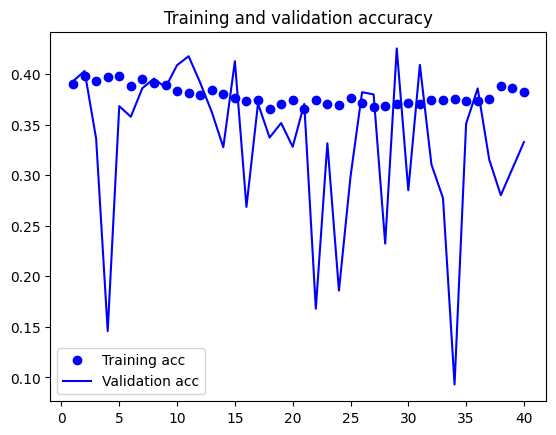

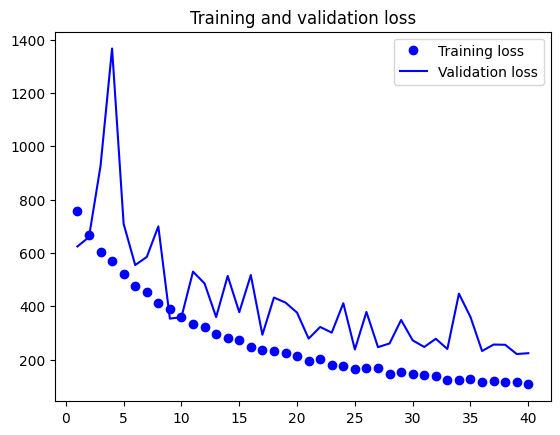

In [94]:
acc = historyTLnoDA.history['acc']
val_acc = historyTLnoDA.history['val_acc']
loss = historyTLnoDA.history['loss']
val_loss = historyTLnoDA.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

let's analize the graphs

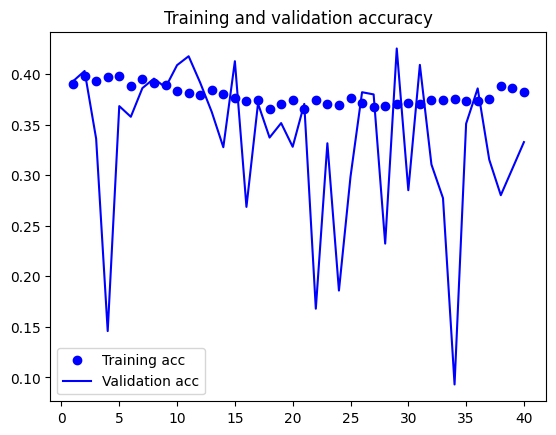

Teh last graph, the trainning accuracy remains relatively stable around 0.35 to 0.40 throughout the epochs, with small fluctuations, but overall the training accuracy does not show significant improvement or degradation over time.
The validation accuracy shows considerable fluctuation, with values ranging from as low as 0.1 to as high as 0.4.The erratic pattern suggests that the model is having difficulty generalizing well to the validation data.

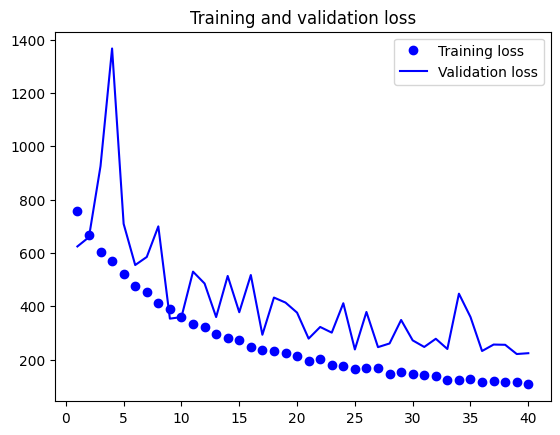

A different comportament has the training loss decreases steadily over the epochs, the initial spike is expected, and as the training progresses, the loss decreases consistently, stabilizing at lower values.
The validation loss fluctuates significantly, starting with high values and then decreasing, but with many spikes throughout the epochs.

Now we will use the “feature extraction” approach with and without data augmentation.

As we approach the end of our project, we will maximize the performance of our model by optimizing it with the following steps:

*   To avoid wasting time, we will implement early stopping.
*   We will also use [checkpoints](https://keras.io/api/callbacks/model_checkpoint/) to save the best model.
*   Fine Tuning let's freez all layers except the last 4
*   Let's create a function that categorizes our data according to the confidence interval for the prediction. This will allow us to classify images that are not vehicles as "not a vehicle."

Let's start without Data agumentation

In [106]:
final_model_noDA = keras.applications.VGG16(include_top=False, weights='imagenet')
final_model_noDA.trainable = True
for layer in final_model_noDA.layers[:-4]:
  layer.trainable = False
inputs = keras.Input(shape=(150, 150, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = final_model_noDA(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.L1L2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(14, activation="softmax")(x)
modeloTLNODA = keras.Model(inputs, outputs)
modeloTLNODA.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 tf.__operators__.getitem_3  (None, 150, 150, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_3 (TFOpLamb  (None, 150, 150, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_13 (Flatten)        (None, 8192)              0         
                                                                 
 dense_26 (Dense)            (None, 512)               419

In [107]:
modeloTLNODA.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])
early_stopping = EarlyStopping(monitor='val_acc', patience=10, mode='max', verbose=1)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_model.h5',monitor='val_acc',save_best_only=True,mode='max',verbose=1)
historyTLDA=modeloTLNODA.fit(amostra_treino, epochs=40, validation_data=amostra_validacao,callbacks=[checkpoint, early_stopping])

Epoch 1/40
432/432 [==============================] - ETA: 0s - loss: 33.2423 - acc: 0.6756
Epoch 1: val_acc improved from -inf to 0.78001, saving model to /content/drive/MyDrive/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


432/432 [==============================] - 68s 151ms/step - loss: 33.2423 - acc: 0.6756 - val_loss: 15.9049 - val_acc: 0.7800
Epoch 2/40
432/432 [==============================] - ETA: 0s - loss: 11.5926 - acc: 0.8009
Epoch 2: val_acc improved from 0.78001 to 0.79650, saving model to /content/drive/MyDrive/best_model.h5
432/432 [==============================] - 65s 148ms/step - loss: 11.5926 - acc: 0.8009 - val_loss: 8.9027 - val_acc: 0.7965
Epoch 3/40
432/432 [==============================] - ETA: 0s - loss: 7.3075 - acc: 0.8446
Epoch 3: val_acc improved from 0.79650 to 0.82412, saving model to /content/drive/MyDrive/best_model.h5
432/432 [==============================] - 64s 146ms/step - loss: 7.3075 - acc: 0.8446 - val_loss: 6.2769 - val_acc: 0.8241
Epoch 4/40
432/432 [==============================] - ETA: 0s - loss: 5.3471 - acc: 0.8678
Epoch 4: val_acc improved from 0.82412 to 0.84235, saving model to /content/drive/MyDrive/best_model.h5
432/432 [==============================

our early stop make our model stop at epoch 17 after the model was 10 epochs without improvment of the accuracy on the validation set

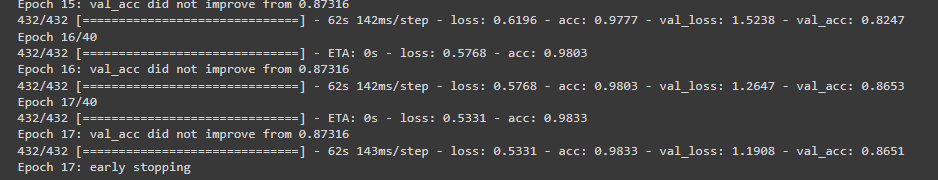

Let's save our model

In [108]:
#model.save('/content/drive/MyDrive/cardatset_finalTLNODA.h5')

lets see the test and the graphs

In [110]:
keras.models.load_model('/content/drive/MyDrive/cardatset_finalTLNODA.h5')
val_loss, val_acc = modeloTLNODA.evaluate(amostra_validacao)
print('val_acc:', round(val_acc,2)*100)
print('val_loss:', round(val_loss,2))

217/217 [==============================] - 21s 94ms/step - loss: 1.1908 - acc: 0.8651
val_acc: 87.0
val_loss: 1.19


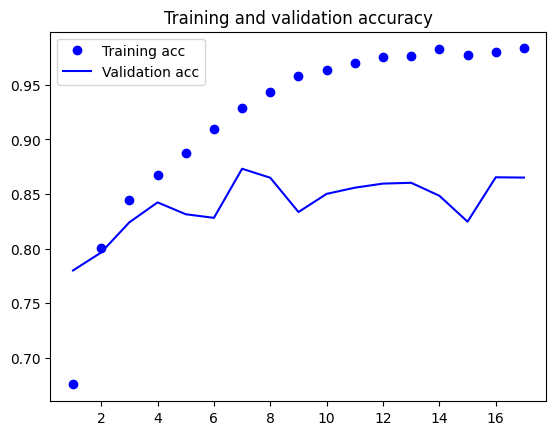

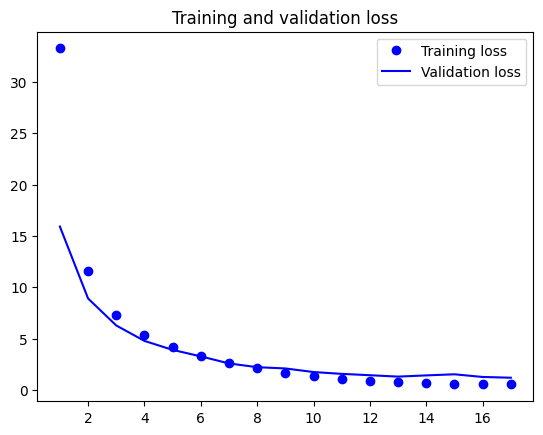

In [111]:
acc = historyTLDA.history['acc']
val_acc = historyTLDA.history['val_acc']
loss = historyTLDA.history['loss']
val_loss = historyTLDA.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Our model with TL and no Data Agumentation

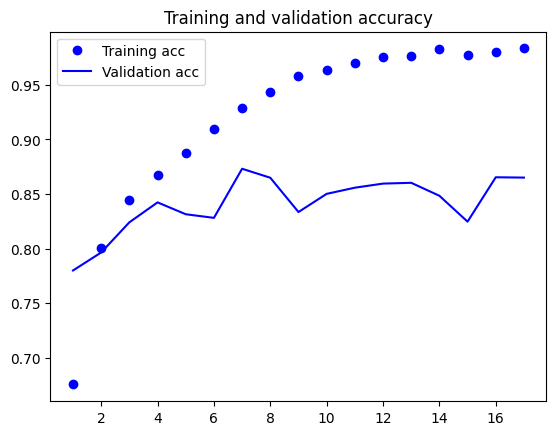

We can see that the training accuracy increases steadily, starting from around 0.70 and reaching nearly 1.00 by the end of the epochs.
This rapid increase indicates that the model is learning the training data very well and may even be memorizing it.
The validation accuracy also improves, starting from around 0.70 and reaching a peak of around 0.90 before slightly declining and stabilizing around 0.85.
The validation accuracy shows some fluctuations, indicating variability in the model's performance on unseen data.
The training accuracy nearing 1.00 while validation accuracy stabilizes lower indicates that the model may be overfitting to the training data.

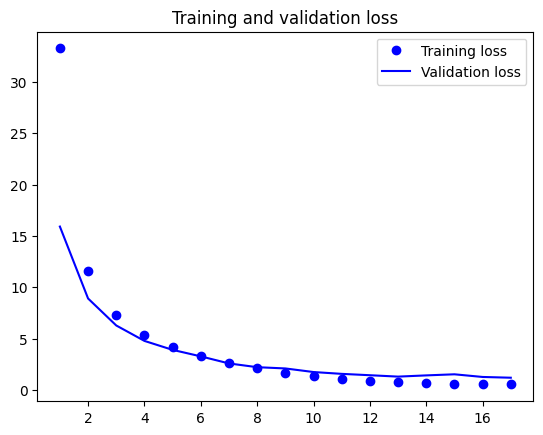

The training loss starts very high (above 30) and decreases rapidly to nearly 0 as epochs progress.This sharp decline in training loss is consistent with the increase in training accuracy, indicating the model is fitting the training data extremely well.
The validation loss also decreases but not as sharply as the training loss, starting high and stabilizing around a lower value after several epochs.
The validation loss exhibits some fluctuations, which correlates with the fluctuations seen in validation accuracy.
The training loss approaching zero also suggests overfitting, as the model is likely memorizing the training data.The fluctuations and eventual stabilization of the validation accuracy and loss, while the training metrics continue to improve, further suggest overfitting.

Let's go now for our last model of our work (TL with DA)


In [113]:
final_model = keras.applications.VGG16(include_top=False, weights='imagenet')
final_model.trainable = True
for layer in final_model.layers[:-4]:
  layer.trainable = False
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = final_model(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.L1L2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(14, activation="softmax")(x)
modelofinal = keras.Model(inputs, outputs)
modelofinal.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 100, 100, 3)       0         
                                                                 
 tf.__operators__.getitem_4  (None, 100, 100, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_4 (TFOpLamb  (None, 100, 100, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_14 (Flatten)        (None, 4608)              0  

In [114]:
modelofinal.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])
early_stopping = EarlyStopping(monitor='val_acc', patience=10, mode='max', verbose=1)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_modelv1.h5',monitor='val_acc',save_best_only=True,mode='max',verbose=1)
historyTLDA=modelofinal.fit(amostra_treino, epochs=40, validation_data=amostra_validacao,callbacks=[checkpoint, early_stopping])

Epoch 1/40
432/432 [==============================] - ETA: 0s - loss: 30.6207 - acc: 0.4043
Epoch 1: val_acc improved from -inf to 0.45835, saving model to /content/drive/MyDrive/best_modelv1.h5
432/432 [==============================] - 68s 148ms/step - loss: 30.6207 - acc: 0.4043 - val_loss: 16.9154 - val_acc: 0.4583
Epoch 2/40
432/432 [==============================] - ETA: 0s - loss: 11.8003 - acc: 0.5309
Epoch 2: val_acc improved from 0.45835 to 0.69178, saving model to /content/drive/MyDrive/best_modelv1.h5
432/432 [==============================] - 66s 151ms/step - loss: 11.8003 - acc: 0.5309 - val_loss: 9.1311 - val_acc: 0.6918
Epoch 3/40
432/432 [==============================] - ETA: 0s - loss: 8.0947 - acc: 0.5717
Epoch 3: val_acc did not improve from 0.69178
432/432 [==============================] - 63s 143ms/step - loss: 8.0947 - acc: 0.5717 - val_loss: 7.6625 - val_acc: 0.5868
Epoch 4/40
432/432 [==============================] - ETA: 0s - loss: 6.3826 - acc: 0.5896
Epoc

In [115]:
#model.save('/content/drive/MyDrive/cardatset_final.h5')

In [116]:
keras.models.load_model('/content/drive/MyDrive/cardatset_final.h5')
val_loss, val_acc = modelofinal.evaluate(amostra_validacao)
print('val_acc:', round(val_acc,2)*100)
print('val_loss:', round(val_loss,2))

217/217 [==============================] - 21s 93ms/step - loss: 1.0547 - acc: 0.7907
val_acc: 79.0
val_loss: 1.05


We could see that our model was still learning, so the best practice is to increase the number of batches in order to allow it to train until it cannot learn any more.

but let's see how our model is beahving

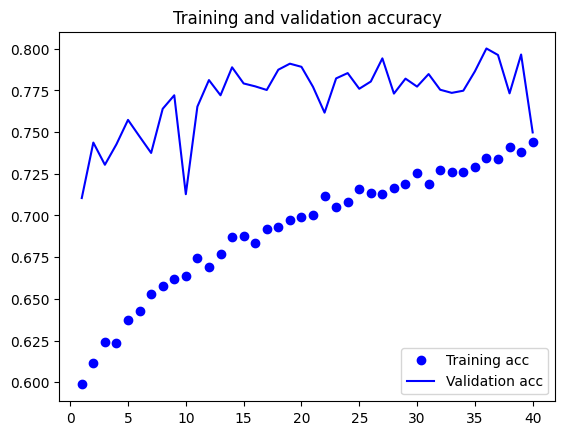

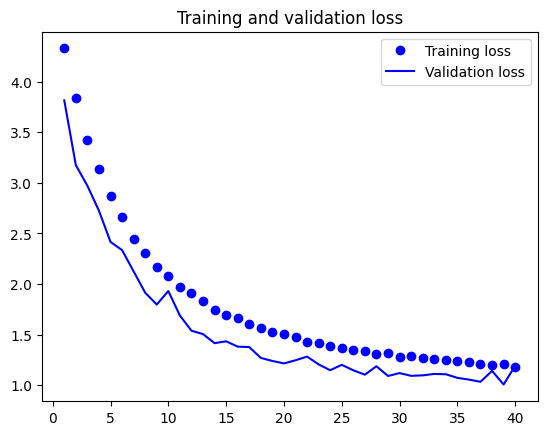

In [103]:
acc = historyTLDA.history['acc']
val_acc = historyTLDA.history['val_acc']
loss = historyTLDA.history['loss']
val_loss = historyTLDA.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

to finalize and in order to have a best model as we can get i will aplly

In [ ]:
modelofinal.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])
early_stopping = EarlyStopping(monitor='val_acc', patience=10, mode='max', verbose=1)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_modelv2.h5',monitor='val_acc',save_best_only=True,mode='max',verbose=1)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
historyTLDA=modelofinal.fit(amostra_treino, epochs=100, validation_data=amostra_validacao,callbacks=[checkpoint, early_stopping])

In [ ]:
#model.save('/content/drive/MyDrive/cardatset_finalV1.h5')

In [ ]:
def predict_with_threshold(model, imagem, threshold=0.5):
    imagem = keras.applications.vgg16.preprocess_input(imagem)
    imagem = np.expand_dims(imagme, axis=0)
    predictions = model.predict(imagem)
    max_prob = np.max(predictions)

    if max_prob < threshold:
        return "não é um veículo"
    else:
        class_idx = np.argmax(predictions)
        return class_idx